# Variational Quantum Eigensolver

A common application of the Variational Quantum Eigensolver (VQE) algorithm is to compute the ground state energy of a molecular system. The code below demonstrates how to perform classical preprocessing for a $H_2$ molecule (i.e. obtain the integrals from a Hartree-Fock computation to build the molecular Hamiltonian), prepare the initial Hartree-Fock state on the quantum register, add the parameterized UCCSD ansatz to the kernel, and select the COBYLA optimizer.  We are then ready to call `cudaq:vqe` to estimate the minimum energy of the system.

In [1]:
# !pip install openfermionpyscf matplotlib scipy

In [54]:
import cudaq
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np

# Single precision
cudaq.set_target("nvidia")
# Double precision
#cudaq.set_target("nvidia-fp64")

The problem of interest here is a chain of hydrogen atoms seperated along the z-axis at a fixed interval called the bond distance. 

The interatomic electrostatic forces due to the electrons and protons and the shielding by the neutrons creates a chemical system whose energy can be minimised to find a stable configuration. 

Let us first begin by defining the molecule and other metadata about the problem.


In [55]:
# Number of hydrogen atoms.
hydrogen_count = 2

# Distance between the atoms in Angstroms.
bond_distance = 0.7474

# Define a linear chain of Hydrogen atoms
geometry = [('H', (0, 0, i * bond_distance)) for i in range(hydrogen_count)]

molecule, data = cudaq.chemistry.create_molecular_hamiltonian(
    geometry, 'sto-3g', 1, 0)


electron_count = data.n_electrons
qubit_count = 2 * data.n_orbitals


We now generate a Unitary Coupled-Cluster Singles and Doubles (UCCSD) ansatz from the template provided by CUDA Quantum.  

In [56]:
@cudaq.kernel
def kernel(thetas: list[float]):

    qubits=cudaq.qvector(qubit_count)

    for i in range(electron_count):
        x(qubits[i])
    
    cudaq.kernels.uccsd(qubits, thetas, electron_count, qubit_count)

parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count,qubit_count)


### Using CUDA Quantum Optimizers

We use the builtin optimizers within CUDA Quantum for the minimization procedure.

In [57]:

optimizer = cudaq.optimizers.COBYLA()

energy, parameters = cudaq.vqe(kernel,
                               molecule,
                               optimizer,
                               parameter_count=parameter_count)

print(energy)


-1.1371744305855906


### Integration with Third-Party Optimizers

We can also integrate popular libraries like scipy with CUDA Quantum. 

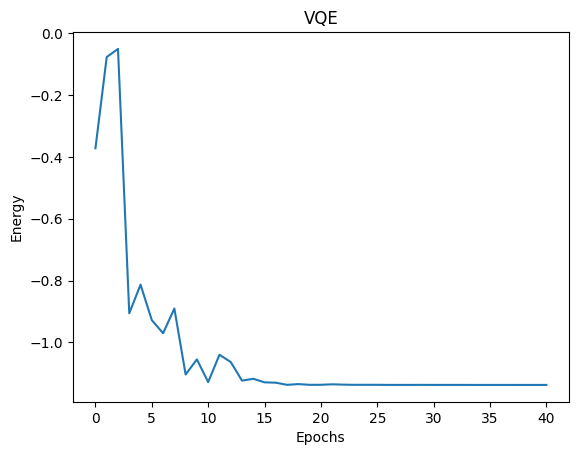

In [58]:
# Define a function to minimize
def to_minimize(theta):

    exp_val = cudaq.observe(kernel, molecule, theta).expectation()

    return exp_val


exp_vals = []


def callback(xk):
    exp_vals.append(to_minimize(xk))


# Initial variational parameters.
x0 = np.random.uniform(low=0, high=2 * np.pi, size=parameter_count)

# Use the scipy optimizer to minimize the function of interest
result = minimize(to_minimize,
                  x0,
                  method='COBYLA',
                  callback=callback,
                  options={'maxiter': 40})

plt.plot(exp_vals)
plt.xlabel('Epochs')
plt.ylabel('Energy')
plt.title('VQE')
plt.show()